# MindLens-AI -- Notebook 02: Model Training

Training a Logistic Regression baseline with 5-fold stratified cross-validation on the RMHD-derived binary dataset (subreddit-based labelling). This notebook also includes ROC/PR curves, error analysis of confident misclassifications, and an optional DistilBERT fine-tuning section.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay

from src.features import build_tfidf
from src.model import train_baseline, save_model, get_device
from src.evaluation import evaluate_single, cross_validate_model, error_analysis

sns.set_theme(style="whitegrid", palette="muted")

device = get_device()
if torch.cuda.is_available():
    print(f"GPU detected: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("No GPU found -- LR runs on CPU anyway, DistilBERT will be slow.")

print("Ready.")

Using device: cuda
GPU detected: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA version: 12.4
Ready.


## 1. Load Data and Build TF-IDF Features

In [2]:
df = pd.read_csv("../data/processed/primary_clean.csv")
print(f"Loaded {len(df)} samples")

all_texts = df["text"].values
all_labels = df["label"].values

vectorizer, tfidf_matrix = build_tfidf(all_texts, max_features=5000)
vocab = vectorizer.get_feature_names_out()
print(f"TF-IDF shape: {tfidf_matrix.shape}")

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    tfidf_matrix, all_labels, np.arange(len(all_labels)),
    test_size=0.2, stratify=all_labels, random_state=42,
)
test_texts = all_texts[idx_test]
print(f"Train: {X_train.shape[0]}  |  Test: {X_test.shape[0]}")

Loaded 19956 samples
TF-IDF shape: (19956, 5000)
Train: 15964  |  Test: 3992


## 2. Cross-Validation (5-Fold Stratified)

In [3]:
cv_table = cross_validate_model(
    LogisticRegression,
    tfidf_matrix, all_labels,
    n_splits=5,
    model_kwargs={"class_weight": "balanced", "max_iter": 1000, "solver": "lbfgs", "random_state": 42},
)
cv_table

  Fold 1: F1=0.7763  ROC-AUC=0.8554981595199818
  Fold 2: F1=0.7743  ROC-AUC=0.8535903152622615
  Fold 3: F1=0.7851  ROC-AUC=0.8641772839801327
  Fold 4: F1=0.7795  ROC-AUC=0.8590080456693063
  Fold 5: F1=0.7836  ROC-AUC=0.8621162123746241


,fold,accuracy,precision,recall,f1,roc_auc,pr_auc
0,1,0.773547,0.767237,0.785679,0.776348,0.855498,0.836367
1,2,0.771235,0.764648,0.784176,0.774289,0.85359,0.827248
2,3,0.784515,0.783541,0.78668,0.785107,0.864177,0.848627
3,4,0.77775,0.773939,0.785178,0.779518,0.859008,0.8418
4,5,0.781508,0.776303,0.791082,0.783623,0.862116,0.849372
5,mean+/-std,0.7777 +/- 0.0055,0.7731 +/- 0.0075,0.7866 +/- 0.0027,0.7798 +/- 0.0046,0.8589 +/- 0.0044,0.8407 +/- 0.0092


## 3. Train Final Model on Train Set

In [4]:
model = train_baseline(X_train, y_train, max_iter=1000)

results = evaluate_single(model, X_test, y_test)
print("--- Test Set Performance ---")
print(results["classification_report"])
print(f"ROC-AUC: {results.get('roc_auc', 'N/A'):.4f}")
print(f"PR-AUC:  {results.get('pr_auc', 'N/A'):.4f}")

--- Test Set Performance ---
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1995
           1       0.76      0.78      0.77      1997

    accuracy                           0.77      3992
   macro avg       0.77      0.77      0.77      3992
weighted avg       0.77      0.77      0.77      3992

ROC-AUC: 0.8515
PR-AUC:  0.8323


## 4. Confusion Matrix, ROC Curve & PR Curve

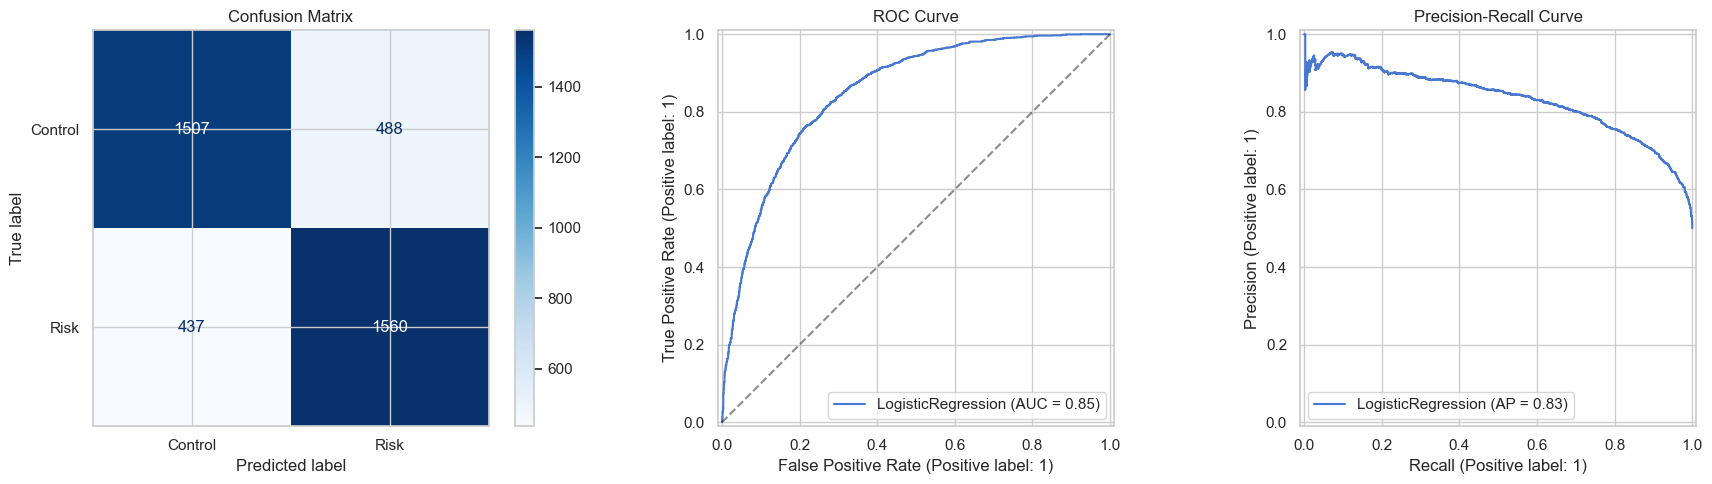

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

cm = results["confusion_matrix"]
ConfusionMatrixDisplay(cm, display_labels=["Control", "Risk"]).plot(ax=axes[0], cmap="Blues")
axes[0].set_title("Confusion Matrix")

RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axes[1])
axes[1].set_title("ROC Curve")
axes[1].plot([0, 1], [0, 1], "k--", alpha=0.5)

PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=axes[2])
axes[2].set_title("Precision-Recall Curve")

plt.tight_layout()
plt.show()

## 5. Error Analysis (Top 20 FP & FN)

In [6]:
fp_df, fn_df = error_analysis(model, X_test, y_test, test_texts, n=20)

print("--- Top 20 False Positives (predicted Risk, actually Control) ---")
for i, row in fp_df.iterrows():
    print(f"\n  [FP-{i+1}] confidence={row['confidence']:.3f}")
    print(f"    {row['text'][:200]}...")

print("\n\n--- Top 20 False Negatives (predicted Control, actually Risk) ---")
for i, row in fn_df.iterrows():
    print(f"\n  [FN-{i+1}] confidence={row['confidence']:.3f}")
    print(f"    {row['text'][:200]}...")

--- Top 20 False Positives (predicted Risk, actually Control) ---

  [FP-1] confidence=0.987
    depressed for over years suicidal for i dont see any reason for me to keep living tried to do some things to make myself better i fucking tried ok keeping on doing same things hoping they would work i...

  [FP-2] confidence=0.983
    i dont want to die but i don t want to live removed...

  [FP-3] confidence=0.977
    goodbye i plan to kill myself tonight i can no longer live every day feeling like this i care so much about everyone around me and nobody really cares about me i just feel useless and like i take up s...

  [FP-4] confidence=0.968
    im going to die be happy humanity no one cares if im dead or im alive...

  [FP-5] confidence=0.967
    im tired i just feel like a burden to everybody around me i dont have enough courage to kill myself it hurts it hurts so fucking much...

  [FP-6] confidence=0.967
    the only thing that stopped me from killing myself tonight is that i didn t

## 6. Save Model Artifacts

In [7]:
save_model(model, vectorizer, "../data/processed/model_artifacts.joblib")

import joblib
joblib.dump({
    "X_test": X_test, "y_test": y_test, "texts_test": test_texts,
    "X_train": X_train, "y_train": y_train,
    "feature_names": list(vocab),
}, "../data/processed/test_split.joblib")
print("Artifacts saved.")

Model saved -> ../data/processed/model_artifacts.joblib
Artifacts saved.


## 7. (Optional) DistilBERT Fine-tuning

Skip this cell if you don't have a GPU with at least 4 GB VRAM.

In [8]:
from src.model import train_distilbert

train_raw = df.iloc[idx_train]["text"].values
test_raw  = df.iloc[idx_test]["text"].values

trainer, tokenizer = train_distilbert(
    train_texts=train_raw,
    train_labels=y_train,
    val_texts=test_raw,
    val_labels=y_test,
    epochs=3,
    batch_size=16,
    output_dir="../data/processed/distilbert_model",
)

print("DistilBERT evaluation:", trainer.evaluate())
print("Done.")


Using device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.444900,0.456654,0.787074,0.799054
2,0.377100,0.465095,0.788577,0.798183
3,0.292200,0.498993,0.787826,0.792351


DistilBERT evaluation: {'eval_loss': 0.45665404200553894, 'eval_accuracy': 0.7870741482965932, 'eval_f1': 0.7990543735224587, 'eval_runtime': 4.943, 'eval_samples_per_second': 807.614, 'eval_steps_per_second': 25.289, 'epoch': 3.0}
Done.
